In this project, we attempt to generate a story from images. A particular use case for this is creatives looking for a little mental boost in their writing processes. An image taken from a phone camera can lead to a writing prompt of sorts and aid the writing/speaking process.

We attemp several things, to create our own models, to use pretrained models, to generate captions and then give to the NLP model etc. Below is our journey, of successes and failures.

The project aim to quite literally implement the idea of "a picture speaks a thousand words".


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import matplotlib.pyplot as plt

Attempt 1: Using a modification of Resnet with a transformer.

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
# Parameters
IMAGES_PATH = "Flicker8k_Dataset"
CAPTIONS_FILE = "Flickr8k.token.txt"
IMAGE_SIZE = (224, 224)
VOCAB_SIZE = 10000
SEQ_LENGTH = 25
BATCH_SIZE = 64
EPOCHS = 10
EMBED_DIM = 512

In [ ]:
# Load GPT-2
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# Load dataset
def load_dataset(image_dir, captions_file):
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")]
    with open(captions_file, "r") as f:
        caption_data = f.readlines()
    caption_mapping = {}
    text_data = []
    for line in caption_data:
        img_name, caption = line.strip().split("\t")
        img_name = os.path.join(image_dir, img_name.split("#")[0].strip())
        caption = f"<start> {caption.strip()} <end>"
        text_data.append(caption)
        if img_name in caption_mapping:
            caption_mapping[img_name].append(caption)
        else:
            caption_mapping[img_name] = [caption]
    return image_paths, caption_mapping, text_data

image_paths, captions_mapping, text_data = load_dataset(IMAGES_PATH, CAPTIONS_FILE)

# Text vectorization
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=lambda txt: tf.strings.regex_replace(txt, r"[^\w\s]", "")
)
vectorizer.adapt(text_data)

In [ ]:
# Build CNN model
def build_cnn_model():
    base_model = tf.keras.applications.ResNet50(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    base_model.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(EMBED_DIM)(x)  # Project to match Transformer embedding dimension
    return tf.keras.Model(inputs=base_model.input, outputs=x)

cnn_model = build_cnn_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Example Transformer Decoder
'''
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

    def call(self, inputs, encoder_outputs, training, mask=None):
        attention_output = self.attention(query=inputs, value=encoder_outputs, key=encoder_outputs)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)
'''

'\nclass TransformerDecoderBlock(layers.Layer):\n    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):\n        super().__init__(**kwargs)\n        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)\n        self.ffn = tf.keras.Sequential([\n            layers.Dense(ff_dim, activation="relu"),\n            layers.Dense(embed_dim),\n        ])\n        self.layernorm1 = layers.LayerNormalization()\n        self.layernorm2 = layers.LayerNormalization()\n\n    def call(self, inputs, encoder_outputs, training, mask=None):\n        attention_output = self.attention(query=inputs, value=encoder_outputs, key=encoder_outputs)\n        out1 = self.layernorm1(inputs + attention_output)\n        ffn_output = self.ffn(out1)\n        return self.layernorm2(out1 + ffn_output)\n'

In [ ]:
# Transformer Decoder
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, vocab_size, **kwargs):
        super().__init__(**kwargs)
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.out = layers.Dense(vocab_size, activation="softmax")

    def call(self, inputs, encoder_outputs, training, mask=None):
        embedded_inputs = self.embedding(inputs)  # Shape: (batch_size, seq_length, embed_dim)
        attention_output = self.attention(query=embedded_inputs, value=encoder_outputs, key=encoder_outputs)
        out1 = self.layernorm1(embedded_inputs + attention_output)
        ffn_output = self.ffn(out1)
        outputs = self.layernorm2(out1 + ffn_output)
        return self.out(outputs)

transformer_decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=512, num_heads=4, vocab_size=VOCAB_SIZE)

In [ ]:
# Image captioning and story generation
'''
def generate_caption_and_story(image_path):
    # Preprocess image
    def preprocess_image(img_path):
        img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
        img = tf.keras.utils.img_to_array(img) / 255.0
        return tf.expand_dims(img, axis=0)

    img = preprocess_image(image_path)
    features = cnn_model(img)

    # Generate Caption
    decoded_caption = "<start> "
    for _ in range(SEQ_LENGTH):
        tokenized_caption = vectorizer([decoded_caption])[:, :-1]
        predictions = transformer_decoder(tokenized_caption, features)
        sampled_token_index = tf.argmax(predictions[0, -1, :]).numpy()
        sampled_token = vectorizer.get_vocabulary()[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += f" {sampled_token}"

    decoded_caption = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip()
    print("Generated Caption: ", decoded_caption)
'''

'\ndef generate_caption_and_story(image_path):\n    # Preprocess image\n    def preprocess_image(img_path):\n        img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)\n        img = tf.keras.utils.img_to_array(img) / 255.0\n        return tf.expand_dims(img, axis=0)\n\n    img = preprocess_image(image_path)\n    features = cnn_model(img)\n\n    # Generate Caption\n    decoded_caption = "<start> "\n    for _ in range(SEQ_LENGTH):\n        tokenized_caption = vectorizer([decoded_caption])[:, :-1]\n        predictions = transformer_decoder(tokenized_caption, features)\n        sampled_token_index = tf.argmax(predictions[0, -1, :]).numpy()\n        sampled_token = vectorizer.get_vocabulary()[sampled_token_index]\n        if sampled_token == "<end>":\n            break\n        decoded_caption += f" {sampled_token}"\n\n    decoded_caption = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip()\n    print("Generated Caption: ", decoded_caption)\n'

In [ ]:
# Generate Story
'''
prompt = f"Image description: {decoded_caption}. Write a detailed story about this scene."
inputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
outputs = gpt2_model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=200,
        num_beams=5,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        no_repeat_ngram_size=3,
)
story = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated Story: ", story)
'''

'\nprompt = f"Image description: {decoded_caption}. Write a detailed story about this scene."\ninputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)\noutputs = gpt2_model.generate(\n        inputs["input_ids"],\n        attention_mask=inputs["attention_mask"],\n        max_length=200,\n        num_beams=5,\n        do_sample=True,\n        temperature=0.7,\n        top_k=50,\n        top_p=0.95,\n        no_repeat_ngram_size=3,\n)\nstory = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)\nprint("Generated Story: ", story)\n'

In [ ]:
# Generate Caption and Story
def generate_caption_and_story(image_path):
    def preprocess_image(img_path):
        img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
        img = tf.keras.utils.img_to_array(img) / 255.0
        return tf.expand_dims(img, axis=0)

    img = preprocess_image(image_path)
    features = cnn_model(img)  # Shape: (batch_size, embed_dim)
    features = tf.expand_dims(features, axis=1)  # Shape: (batch_size, 1, embed_dim)

    # Generate Caption
    decoded_caption = "<start> "
    for _ in range(SEQ_LENGTH):
        tokenized_caption = vectorizer([decoded_caption])[:, :-1]
        predictions = transformer_decoder(tokenized_caption, features, training=False)
        sampled_token_index = tf.argmax(predictions[0, -1, :]).numpy()
        sampled_token = vectorizer.get_vocabulary()[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += f" {sampled_token}"

    decoded_caption = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip()
    print("Generated Caption: ", decoded_caption)

    # Generate Story
    prompt = f"Image description: {decoded_caption}. Write a detailed story about this scene."
    inputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    outputs = gpt2_model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=200,
        num_beams=5,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        no_repeat_ngram_size=3,
    )
    story = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Generated Story: ", story)

In [ ]:
# Test with a sample image
generate_caption_and_story(image_paths[0])

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 24, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Caption:  bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing buy buy
Generated Story:  Image description: bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing bearing buy buy. Write a detailed story about this scene.

Note: This story is not a complete story. It may contain inaccuracies or other inaccuracies. If you have any questions about this story, please contact us.


Attempt 2: Due to running into dimension errors we try to caption the images from a modfication of the VGG 16 with trial and error. The model successfully starts training here but takes too long. With limited GPU capabilities, we are forced to focus on another attempt. Code commented along the way

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
# Load VGG16 model without the top layer
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Function to extract features from an image
def extract_features(image_path, model):
    img = Image.open(image_path).resize((224, 224))
    img = np.array(img)
    if img.shape[-1] == 4:  # Convert RGBA to RGB if needed
        img = img[..., :3]
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input
    img = tf.keras.applications.vgg16.preprocess_input(img)
    features = model.predict(img, verbose=0)
    return features


In [ ]:
def load_descriptions(filepath):
    file = open(filepath, 'r')
    text = file.read()
    file.close()
    descriptions = {}
    for line in text.strip().split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = []
        descriptions[image_id].append(image_desc)
    return descriptions

def load_photos(filepath):
    with open(filepath, 'r') as file:
        photos = file.read().strip().split('\n')
    return [photo.split('.')[0] for photo in photos]  # Remove '.jpg' if present

def load_features(photo_ids, directory):
    features = {}
    for image_id in photo_ids:
        filename = os.path.join(directory, image_id + '.jpg')
        if os.path.exists(filename):
            features[image_id] = extract_features(filename, model)
        else:
            print(f"Warning: {filename} does not exist.")
    return features


descriptions = load_descriptions('Flickr8k.token.txt')
train_images = load_photos('Flickr_8k.trainImages.txt')
train_features = load_features(train_images, 'Flicker8k_Dataset')


In [ ]:
def create_tokenizer(descriptions):
    lines = []
    for key in descriptions.keys():
        lines.extend(descriptions[key])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def create_sequences(tokenizer, max_length, descriptions, features):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
      if key not in features:
        continue
      for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(features[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences([desc for desc_list in descriptions.values() for desc in desc_list]))


In [ ]:
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = define_model(vocab_size, max_length)


In [ ]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, descriptions, train_features)
model.fit([X1train, X2train], ytrain, epochs=20, batch_size=32, verbose=2)


NameError: name 'create_sequences' is not defined

In [ ]:
print(f"Descriptions keys: {list(descriptions.keys())}")  # Example output
print(f"Train features keys: {list(train_features.keys())[:5]}")  # Example output


Descriptions keys: ['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_81

In [ ]:
# Generate caption for a new image
def generate_caption_for_image(image_path, feature_extractor, model, tokenizer, max_length):
    img = load_image(image_path)

    if img is not None:
        # Extract features dynamically
        feature = feature_extractor.predict(np.expand_dims(img, axis=0))
        feature = np.squeeze(feature)  # Remove extra dimensions

        # Generate caption
        generated_caption = generate_caption(model, tokenizer, feature, max_length)
        return generated_caption
    else:
        return "Failed to load image."

In [ ]:
    # Test on a random image
    random_image = random.choice(os.listdir(images_path))
    random_image_path = os.path.join(images_path, random_image)
    caption = generate_caption_for_image(random_image_path, feature_extractor, model, tokenizer, max_length)

    # Display the image and caption
    img = Image.open(random_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Caption: {caption}")
    plt.show()


**Good One**

Attempt 3: We aim to more scinetifically preprocess the data and use it to generate captions instead of directly feeding the image data to the NLP model. A story generated from captions might make more sense. This approach successfully captions the images. The code is commented as needed

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

In [ ]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


In [ ]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.1343 - loss: 35.2315 - val_acc: 0.3079 - val_loss: 20.4739
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 94s 973ms/step - acc: 0.3182 - loss: 20.0209 - val_acc: 0.3495 - val_loss: 18.0324
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.3514 - loss: 17.7896 - val_acc: 0.3672 - val_loss: 16.9468
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 94s 974ms/step - acc: 0.3702 - loss: 16.6421 - val_acc: 0.3780 - val_loss: 16.3324
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - acc: 0.3862 - loss: 15.7833 - val_acc: 0.3887 - val_loss: 15.8738
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - acc: 0.3983 - loss: 15.1027 - val_acc: 0.3945 - val_loss: 15.5975
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 93s 966ms/step - acc: 0.4076 - loss: 14.5992 - val_acc: 0.3986 - val_loss: 15.3779
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 972ms/step - acc: 0.4178 - loss: 14.0853 - val_acc: 0.4029 - val_loss: 15.2138
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step

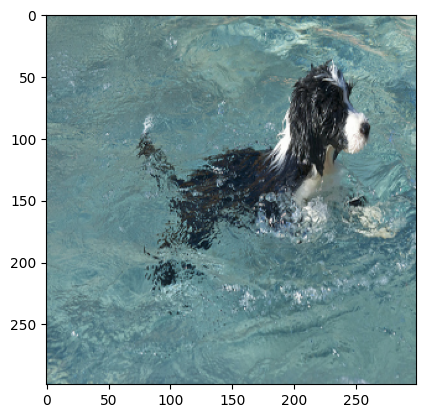

Predicted Caption:  a black and white dog swims in a pool


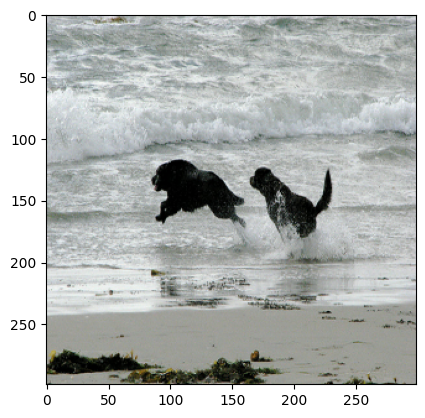

Predicted Caption:  two dogs run through the water


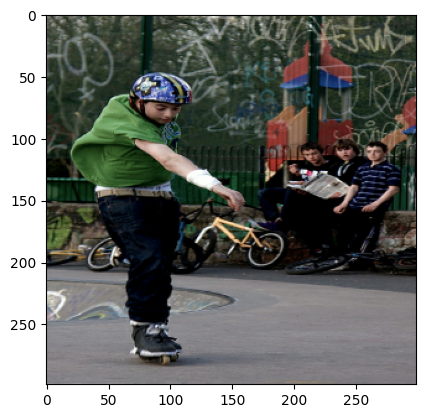

Predicted Caption:  a man in a green shirt and blue jeans is riding a unicycle


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


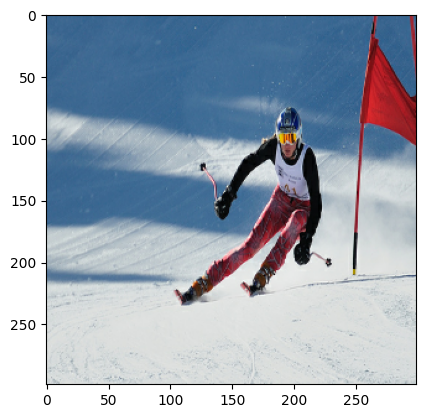

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:5

Predicted Caption:  a snowboarder in a blue jacket is performing a trick on a snowboard
Generated Story:  Image description: a snowboarder in a blue jacket is performing a trick on a snowboard. Write a detailed story about this scene.

Description: This is the scene in which the Snowboarders are performing the trick. The trick is to pull the snow off the top of the skis, and then pull it back down to the ground. It's a very simple trick, but it's one of those things where you have to do a lot of work to get it to work. You can't do it all at once, so you need to figure out how to make it work at the same time. In this case, I'm going to show you how you can do this trick in two different ways. First, you'll be doing this in the first place. Second, if you're not familiar with snowboarding, then you probably don't want to read about it. So, let's get started.


Step 1: Pull the Skis Back Down



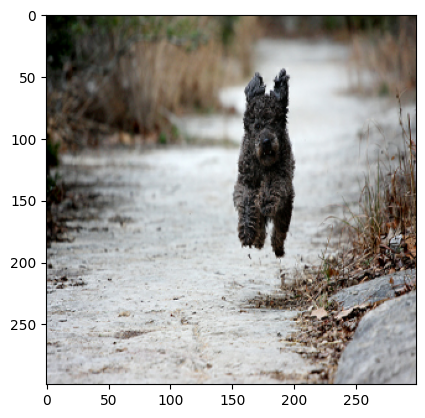

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predicted Caption:  a black dog runs through the snow
Generated Story:  Image description: a black dog runs through the snow. Write a detailed story about this scene.

This story was originally published on The Conversation. Read the original article.


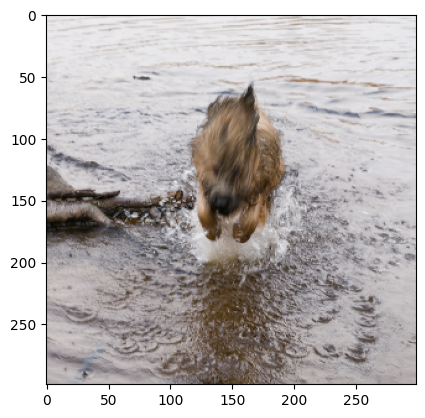

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predicted Caption:  a dog is running through the snow
Generated Story:  Image description: a dog is running through the snow. Write a detailed story about this scene.

This story was originally published on The Conversation. Read the original article.


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load GPT-2 model and tokenizer globally
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add the padding token and resize embeddings
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))  # Resize embeddings to include the padding token

def generate_caption_and_story():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

    # Generate a story using GPT-2
    prompt = f"Image description: {decoded_caption}. Write a detailed story about this scene."
    inputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

    # Generate story with appropriate attention mask
    outputs = gpt2_model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=200,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
    )
    story = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Generated Story: ", story)

# Check predictions and story generation for a few samples
generate_caption_and_story()
generate_caption_and_story()
generate_caption_and_story()


With that done, we now try to replicate this with a homemade CNN and see how far we can get. Captions along the way as usual

In [ ]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Dropout, Activation
from keras.layers import Add, Input, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

In [ ]:
annotations = './Flickr8k.token.txt'
images_path = './Flicker8k_Dataset/'

In [ ]:
# Load and preprocess captions
def load_captions(filepath):
    captions = {}
    with open(filepath, 'r') as file:
        for line in file:
            # Split by tab to separate the image ID and the caption
            tokens = line.strip().split('\t')
            if len(tokens) < 2:  # Skip lines without a valid caption
                continue
            image_id, caption = tokens[0], tokens[1]
            # Remove the "#<number>" part from the image ID
            image_id = image_id.split('#')[0].split('.')[0]
            # Preprocess the caption
            caption = caption.translate(str.maketrans('', '', string.punctuation)).lower()
            # Add the "startseq" and "endseq" tokens
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(f'startseq {caption} endseq')
    return captions

# Example usage
captions = load_captions(annotations)

In [ ]:
print(captions)

{'1000268201_693b08cb0e': ['startseq a child in a pink dress is climbing up a set of stairs in an entry way  endseq', 'startseq a girl going into a wooden building  endseq', 'startseq a little girl climbing into a wooden playhouse  endseq', 'startseq a little girl climbing the stairs to her playhouse  endseq', 'startseq a little girl in a pink dress going into a wooden cabin  endseq'], '1001773457_577c3a7d70': ['startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tricolored dog playing with each other on the road  endseq', 'startseq a black dog and a white dog with brown spots are staring at each other in the street  endseq', 'startseq two dogs of different breeds looking at each other on the road  endseq', 'startseq two dogs on pavement moving toward each other  endseq'], '1002674143_1b742ab4b8': ['startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  endseq', 'startseq a little girl is sitting in fron

In [ ]:
# Load and preprocess images
def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0
    return img

def load_images(images_dir, captions):
    images = {}
    for image_id in captions:
        image_path = os.path.join(images_dir, image_id + '.jpg')
        if os.path.exists(image_path):
            images[image_id] = preprocess_image(image_path)
    return images

images = load_images(images_path, captions)

In [ ]:
# Tokenize captions
def create_tokenizer(captions):
    all_captions = []
    for key in captions:
        all_captions.extend(captions[key])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    return tokenizer

tokenizer = create_tokenizer(captions)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
missing_images = [image_id for image_id in captions if image_id not in images]
print(f"Missing images: {missing_images}")


Missing images: ['2258277193_586949ec62']


In [ ]:
# Create data generator
def data_generator(tokenizer, captions, images, max_length, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for image_id, caption_list in captions.items():
            if image_id not in images:  # Skip missing images
                continue
            for caption in caption_list:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(images[image_id])
                    X2.append(in_seq)
                    y.append(out_seq)
                    n += 1
                    if n == batch_size:
                        yield ((np.array(X1), np.array(X2)), np.array(y))
                        X1, X2, y = [], [], []
                        n = 0

max_length = max(len(caption.split()) for caption_list in captions.values() for caption in caption_list)
batch_size = 64
steps_per_epoch = len(captions) // batch_size

In [ ]:
# Define CNN for image feature extraction
def create_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten()
    ])
    return model

In [ ]:
# Define Transformer block
def transformer_block(vocab_size, max_length):
    text_input = Input(shape=(max_length,))
    x = Embedding(vocab_size, 256, input_length=max_length)(text_input)
    x = MultiHeadAttention(num_heads=8, key_dim=256)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)  # Align shape with CNN output
    return Model(inputs=text_input, outputs=x)



In [ ]:
# Combine CNN and Transformer
def create_model(input_shape, vocab_size, max_length):
    cnn = create_cnn(input_shape)

    image_input = Input(shape=input_shape)
    image_features = cnn(image_input)
    image_features = Dense(256, activation='relu')(image_features)  # Align shape

    transformer = transformer_block(vocab_size, max_length)

    text_input = Input(shape=(max_length,))
    text_features = transformer(text_input)

    combined = Add()([image_features, text_features])
    combined = Dense(256, activation='relu')(combined)  # Added layer to stabilize output
    output = Dense(vocab_size, activation='softmax')(combined)

    model = Model(inputs=[image_input, text_input], outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy')
    return model

# Define and train the model
input_shape = (128, 128, 3)
model = create_model(input_shape, vocab_size, max_length)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
with tf.device('/GPU:0'):  # '/GPU:0' is the default GPU
    checkpoint = ModelCheckpoint('./best_model.keras', save_best_only=False, verbose=1)
    model.fit(data_generator(tokenizer, captions, images, max_length, batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=20,
              callbacks=[checkpoint])

Epoch 1/20
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 6.4341
Epoch 1: saving model to ./best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 6.4255
Epoch 2/20
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 5.5589
Epoch 2: saving model to ./best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 5.5581
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.6318
Epoch 3: saving model to ./best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 5.6311
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.5034
Epoch 4: saving model to ./best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 5.5031
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.4794
Epoch 5: saving model to ./best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 5.4784
Epoch 6/20
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.2143
Epoch 6: saving model to ./best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step 

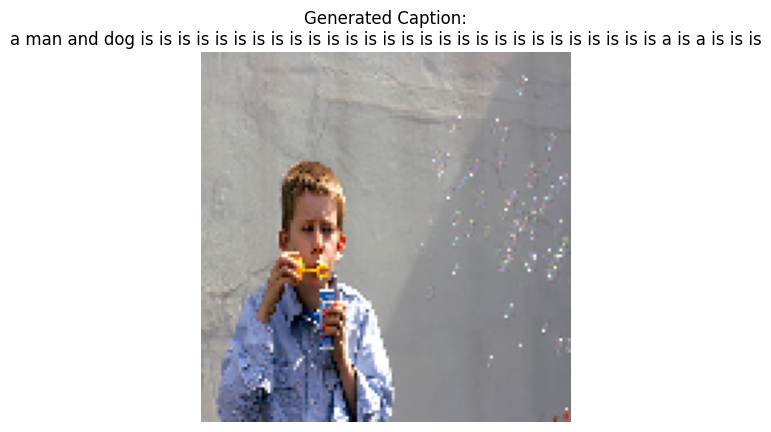

Original Captions for 2467853482_17009933e8:
1. startseq a boy blowing bubbles  endseq
2. startseq a boy in a blue shirt blows bubbles  endseq
3. startseq a boy in blue is blowing bubbles  endseq
4. startseq a boy is blowing bubbles endseq
5. startseq a young boy wearing a blue shirt blows bubbles  endseq


In [ ]:
import random
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

# Function to generate captions using the trained model
def generate_caption(model, tokenizer, image, max_length):
    input_image = np.expand_dims(image, axis=0)  # Add batch dimension
    caption = "startseq"
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([caption])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        y_pred = model.predict([input_image, seq], verbose=0)
        word_index = np.argmax(y_pred)
        word = tokenizer.index_word.get(word_index)
        if word is None or word == "endseq":
            break
        caption += " " + word
    return caption.replace("startseq", "").replace("endseq", "").strip()

# Pick a random image from the dataset
def get_random_image_and_caption(images, captions):
    random_image_id = random.choice(list(images.keys()))
    random_image = images[random_image_id]
    original_captions = captions[random_image_id]
    return random_image_id, random_image, original_captions

# Get a random image and its original captions
random_image_id, random_image, original_captions = get_random_image_and_caption(images, captions)

# Generate a caption for the random image
model = load_model('./best_model.keras')
generated_caption = generate_caption(model, tokenizer, random_image, max_length)

# Display the image and captions
plt.imshow(random_image)
plt.axis("off")
plt.title(f"Generated Caption:\n{generated_caption}")
plt.show()

print(f"Original Captions for {random_image_id}:")
for idx, caption in enumerate(original_captions, 1):
    print(f"{idx}. {caption}")


We did manage to create and run our own homemade CNN, but we can see that it does not do a very good job. We should thus stick to the prebuilt ones created by smarter people. On an optimistic note, with lots of research effort, a model built from scratch might emulate a pre built one. No need to do that though, better ones exist :)